### Cut out and process SOGOS region from global climatology for easier plotting

In [1]:
import numpy as np
import gsw
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cmocean 

The climatology data should be downloaded from https://sio-argo.ucsd.edu/RG_Climatology.html.

In [2]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data/data/'
# Climatology data
Tclim = xr.open_dataset(data_dir + "raw/RG_climatology/RG_ArgoClim_Temperature_2019.nc", decode_times=False)
Sclim = xr.open_dataset(data_dir + "raw/RG_climatology/RG_ArgoClim_Salinity_2019.nc", decode_times=False)

RG_clim = xr.merge([Tclim, Sclim])

# Calendar type was missing, and giving errors in decoding time
RG_clim.TIME.attrs['calendar'] = '360_day'
RG_clim = xr.decode_cf(RG_clim)

RG_clim_mean = RG_clim[['ARGO_TEMPERATURE_MEAN', 'ARGO_SALINITY_MEAN']]

#### Select region

In [3]:
RG_clim_SOGOS_region = RG_clim_mean.sel(LONGITUDE=slice(20, 50),
                                   LATITUDE=slice(-60,-45),
                                   PRESSURE=slice(0,1200))

#### Compute more thermodynamic variables

In [4]:
## Add density and other things 
SA = xr.apply_ufunc(gsw.SA_from_SP, RG_clim_SOGOS_region.ARGO_SALINITY_MEAN, 
                                    RG_clim_SOGOS_region.PRESSURE , 
                                    RG_clim_SOGOS_region.LONGITUDE, 
                                    RG_clim_SOGOS_region.LATITUDE,
                                    dask='parallelized', output_dtypes=[float,]).rename('SA')

CT = xr.apply_ufunc(gsw.CT_from_t, SA, RG_clim_SOGOS_region.ARGO_TEMPERATURE_MEAN, 
                                       RG_clim_SOGOS_region.PRESSURE, 
                     dask='parallelized', output_dtypes=[float,]).rename('CT')

SIGMA0 = xr.apply_ufunc(gsw.sigma0, SA, CT, dask='parallelized', output_dtypes=[float,]).rename('SIGMA0')


In [5]:
RG_clim_SOGOS_region = xr.merge([RG_clim_SOGOS_region, SA, CT, SIGMA0])

In [6]:
RG_clim_SOGOS_region

<xarray.Dataset>
Dimensions:                (PRESSURE: 48, LATITUDE: 15, LONGITUDE: 30)
Coordinates:
  * LONGITUDE              (LONGITUDE) float32 20.5 21.5 22.5 ... 47.5 48.5 49.5
  * LATITUDE               (LATITUDE) float32 -59.5 -58.5 -57.5 ... -46.5 -45.5
  * PRESSURE               (PRESSURE) float32 2.5 10.0 20.0 ... 1.15e+03 1.2e+03
Data variables:
    ARGO_TEMPERATURE_MEAN  (PRESSURE, LATITUDE, LONGITUDE) float32 ...
    ARGO_SALINITY_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 ...
    SA                     (PRESSURE, LATITUDE, LONGITUDE) float64 33.98 ... ...
    CT                     (PRESSURE, LATITUDE, LONGITUDE) float64 -0.6903 .....
    SIGMA0                 (PRESSURE, LATITUDE, LONGITUDE) float64 27.19 ... ...

#### Interpolate to isopycnal grid

In [7]:
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

# Interpolate onto density surface 

RG_clim_SOGOS_region = generate_grid_ds(RG_clim_SOGOS_region, 
                {'Z':'PRESSURE',  'Y':'LATITUDE', 'X':'LONGITUDE'})
grid = Grid(RG_clim_SOGOS_region, periodic=False)

iso_target = np.linspace(26.7, 27.9, 41)

In [8]:
PRESSURE_broad, _ = xr.broadcast(RG_clim_SOGOS_region.PRESSURE, RG_clim_SOGOS_region.SIGMA0) 
#need to do this because PRESSURE is 1D

PRES_transformed = grid.transform(PRESSURE_broad, 'Z',
                                 iso_target, target_data = RG_clim_SOGOS_region.SIGMA0.rename('iso_SIGMA0')).rename('iso_PRESSURE')
CT_transformed = grid.transform(RG_clim_SOGOS_region.CT, 'Z',
                                 iso_target, target_data = RG_clim_SOGOS_region.SIGMA0.rename('iso_SIGMA0')).rename('iso_CT')
SA_transformed = grid.transform(RG_clim_SOGOS_region.SA, 'Z',
                                 iso_target, target_data = RG_clim_SOGOS_region.SIGMA0.rename('iso_SIGMA0')).rename('iso_SA')

In [9]:
RG_clim_SOGOS_region_iso = xr.merge([PRES_transformed, SA_transformed, CT_transformed])

#### Merge datasets and save

In [10]:
RG_clim_SOGOS = xr.merge([RG_clim_SOGOS_region_iso, RG_clim_SOGOS_region])

In [11]:
RG_clim_SOGOS.to_netcdf('../data/RG_clim_SOGOS.nc')

#### Some plots to check 

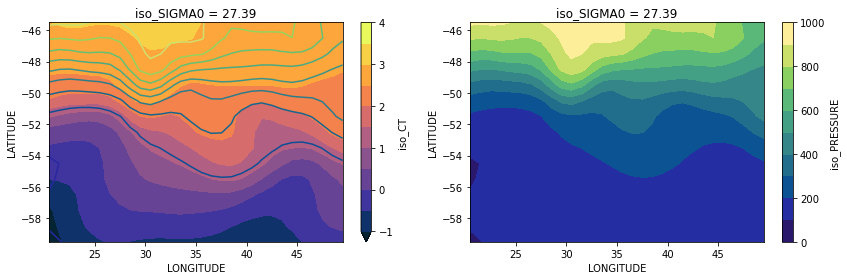

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
RG_clim_SOGOS.iso_CT.sel(iso_SIGMA0=27.4, method='nearest').plot.contourf(levels=np.linspace(-1,4, 11),
                                                                            cmap=cmocean.cm.thermal)
RG_clim_SOGOS.iso_PRESSURE.sel(iso_SIGMA0=27.4, method='nearest').plot.contour(levels=11,
                                                                            cmap=cmocean.cm.haline)

plt.subplot(122)
RG_clim_SOGOS.iso_PRESSURE.sel(iso_SIGMA0=27.4, method='nearest').plot.contourf(levels=11,
                                                                            cmap=cmocean.cm.haline)

plt.tight_layout()